Setup libraries

In [21]:
from pystac_client import Client
from dask.distributed import Client as DaskClient
from odc.stac import load, configure_s3_access
import rasterio as rio
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import folium
import utils
from utils import load_data
# from utils import mask_and_scale
from sklearn.ensemble import RandomForestClassifier
import odc.geo.xr
import rioxarray
import matplotlib.pyplot as plt
import joblib
# comment


Define catalogue

In [22]:
min_lat = -18.20459
min_lon = 178.33041
max_lat = -18.10000
max_lon = 178.53506
bbox = [min_lon, min_lat, max_lon, max_lat]

In [23]:
# Define training data

suva_gdf = gpd.read_file("training_data/south_suva_tdata_14022025.geojson")
suva_gdf = suva_gdf.to_crs("EPSG:4326")
suva_gdf.explore(column="cc_id", legend=True)


In [40]:
print(len(suva_gdf))
# suva_gdf

3534


In [41]:
# Open the Zarr dataset
suva_geomad = xr.open_zarr("preprocessing/suva-masked-geomad-v2-2024.zarr", consolidated=True)

# Print dataset details
# print(suva_geomad)

In [44]:
# suva_geomad

In [45]:
# suva_geomad.odc.explore(bands=("red", "green", "blue"), vmin=0, vmax=0.3)


In [46]:
suva_geomad =suva_geomad.to_array(dim="band")

# First transform the training points to the same CRS as the data
suva_training = suva_gdf.to_crs(suva_geomad.odc.geobox.crs)

In [53]:
# Next get the X and Y values out of the point geometries
suva_training_da = suva_training.assign(x=suva_training.geometry.x, y=suva_training.geometry.y).to_xarray()
# suva_training_da

In [54]:
# Now we can use the x and y values (lon, lat) to extract values from the median composite
suva_training_values = (
    suva_geomad.sel(suva_training_da[["x", "y"]], method="nearest").squeeze().compute().to_pandas()
)
suva_training_values

index         0         1         2         3         4         5     \
band                                                                   
bcmad     0.000026  0.000024  0.000022  0.000023  0.000023  0.000025   
blue      0.060900  0.065700  0.066100  0.059000  0.058500  0.055200   
coastal   0.060900  0.059800  0.058600  0.054900  0.052900  0.050300   
count     0.002900  0.002800  0.002600  0.002600  0.002500  0.002500   
emad      0.087519  0.088532  0.083144  0.068808  0.060051  0.059695   
green     0.068900  0.076400  0.078400  0.068900  0.066800  0.062900   
nir       0.036800  0.037500  0.037800  0.032900  0.031600  0.025400   
nir08     0.035800  0.036400  0.035100  0.029800  0.026800  0.022600   
nir09     0.049600  0.043300  0.046400  0.035700  0.031900  0.029800   
red       0.051900  0.058400  0.060400  0.051900  0.048300  0.043600   
rededge1  0.060600  0.063900  0.064900  0.056400  0.052700  0.044100   
rededge2  0.038900  0.039700  0.038500  0.033200  0.030000  0.025300   
rededge3  0.042100  0.043600  0.041700  0.036300  0.032600  0.027100   
smad      0.000007  0.000006  0.000006  0.000006  0.000005  0.000004   
swir16    0.023200  0.022200  0.020200  0.019000  0.018400  0.018000   
swir22    0.020300  0.019500  0.017900  0.017100  0.016300  0.015500   

index         6         7         8         9     ...      3524      3525  \
band                                              ...                       
bcmad     0.000023  0.000025  0.000025  0.000026  ...  0.000029  0.000027   
blue      0.058300  0.060200  0.066600  0.059400  ...  0.055400  0.052200   
coastal   0.054100  0.055300  0.058000  0.054700  ...  0.054400  0.052000   
count     0.002500  0.002500  0.002500  0.002500  ...  0.002500  0.002600   
emad      0.069015  0.072418  0.076758  0.070789  ...  0.071085  0.059796   
green     0.066600  0.070400  0.078800  0.068500  ...  0.058300  0.055500   
nir       0.034000  0.035900  0.038900  0.033900  ...  0.027100  0.023000   
nir08     0.031200  0.033200  0.035700  0.031400  ...  0.025900  0.023100   
nir09     0.032500  0.033400  0.035400  0.032500  ...  0.039100  0.036000   
red       0.050200  0.055100  0.060900  0.052200  ...  0.036400  0.033000   
rededge1  0.057700  0.060300  0.066700  0.060200  ...  0.034900  0.031300   
rededge2  0.035100  0.036300  0.040300  0.035500  ...  0.027900  0.024800   
rededge3  0.038000  0.039800  0.043500  0.038500  ...  0.028700  0.025700   
smad      0.000006  0.000006  0.000007  0.000006  ...  0.000007  0.000004   
swir16    0.018600  0.019400  0.019800  0.018800  ...  0.020500  0.018600   
swir22    0.016400  0.017500  0.017400  0.016300  ...  0.019500  0.017600   

index         3526      3527      3528      3529      3530      3531  \
band                                                                   
bcmad     0.000031  0.000037  0.000027  0.000026  0.000028  0.000029   
blue      0.057600  0.057600  0.046000  0.049300  0.053500  0.055600   
coastal   0.056800  0.059900  0.047300  0.048100  0.053800  0.054500   
count     0.002200  0.002300  0.002200  0.002200  0.002500  0.002600   
emad      0.081073  0.081550  0.051987  0.060282  0.065890  0.071145   
green     0.063000  0.064100  0.050900  0.054500  0.056900  0.058700   
nir       0.027800  0.029200  0.017200  0.020200  0.022800  0.025300   
nir08     0.027200  0.030500  0.016700  0.019400  0.022500  0.025500   
nir09     0.045500  0.049800  0.019600  0.031200  0.033300  0.038000   
red       0.039100  0.043200  0.030700  0.031200  0.033000  0.036500   
rededge1  0.037000  0.041000  0.028100  0.028500  0.031000  0.034300   
rededge2  0.029700  0.032400  0.019100  0.021900  0.024400  0.027600   
rededge3  0.030300  0.033500  0.019800  0.022700  0.025300  0.028600   
smad      0.000004  0.000008  0.000003  0.000005  0.000003  0.000005   
swir16    0.022200  0.025300  0.011700  0.015000  0.017800  0.020700   
swir22    0.020800  0.024400  0.010700  0.013900  0.016800  0.019900   

index         3532 

In [51]:
# Join the training data with the extracted values and remove unnecessary columns
suva_training_array = pd.concat([suva_training["cc_id"], suva_training_values.transpose()], axis=1)

# # Drop rows where there was no data available
# training_array = training_array.dropna()

# Preview our resulting training array
suva_training_array.head()

cc_id     bcmad    blue  coastal   count      emad   green     nir   nir08  \
0      4  0.000026  0.0609   0.0609  0.0029  0.087519  0.0689  0.0368  0.0358   
1      4  0.000024  0.0657   0.0598  0.0028  0.088532  0.0764  0.0375  0.0364   
2      4  0.000022  0.0661   0.0586  0.0026  0.083144  0.0784  0.0378  0.0351   
3      4  0.000023  0.0590   0.0549  0.0026  0.068808  0.0689  0.0329  0.0298   
4      4  0.000023  0.0585   0.0529  0.0025  0.060051  0.0668  0.0316  0.0268   

    nir09     red  rededge1  rededge2  rededge3      smad  swir16  swir22  
0  0.0496  0.0519    0.0606    0.0389    0.0421  0.000007  0.0232  0.0203  
1  0.0433  0.0584    0.0639    0.0397    0.0436  0.000006  0.0222  0.0195  
2  0.0464  0.0604    0.0649    0.0385    0.0417  0.000006  0.0202  0.0179  
3  0.0357  0.0519    0.0564    0.0332    0.0363  0.000006  0.0190  0.0171  
4  0.0319  0.0483    0.0527    0.0300    0.0326  0.000005  0.0184  0.0163

In [50]:
print('suva training data', len(training_array), 'points')

suva training data 3534 points


In [28]:
# The classes are the first column
classes = np.array(training_array)[:, 0]

# The observation data is everything after the first column
observations = np.array(training_array)[:, 1:]

# Create a model...
classifier = RandomForestClassifier()

# ...and fit it to the data
model = classifier.fit(observations, classes)

In [29]:
# Convert to a stacked array of observations
stacked_arrays = s2_geomad.stack(dims=["y", "x"]).transpose()

# Predict the classes
predicted = model.predict(stacked_arrays)

# Reshape back to the original 2D array
array = predicted.reshape(len(s2_geomad.y), len(s2_geomad.x))

# Convert to an xarray again, because it's easier to work with
predicted_da = xr.DataArray(
    array, coords={"y": s2_geomad.y, "x": s2_geomad.x}, dims=["y", "x"]
)

In [30]:
print(predicted_da.dtype)  # Check the dtype of your DataArray
predicted_da = predicted_da.astype('float32')  # Convert to float32

float64


In [31]:

# Check for NaN values
if np.isnan(predicted_da).any():
    print("NaN values found in the data")
    # Handle NaN values, e.g. by filling them
    predicted_da = predicted_da.fillna(0)  # Replace NaN with 0 or appropriate value

In [32]:
# Check if CRS is set, if not set it
# if not [predicted_da.rio.crs:
#     predicted_da = predicted_da.rio.write_crs("EPSG:4326")  # Set to appropriate CRS

In [33]:
# Put it all on a single interactive map
# center = [np.mean([min_lat[0], max_lat[0]]), np.mean([min_lat[1], max_lat[1]])]
# m = folium.Map(location=center, zoom_start=11)

center = [(min_lat + max_lat) / 2, (min_lon + max_lon) / 2]  # Assuming min_lon and max_lon are defined
m = folium.Map(location=center, zoom_start=13)



# RGB for the median
# predicted_da.odc.to_rgba(bands=("red", "green", "blue"), vmin=0, vmax=0.3).odc.add_to(m, name="Median Composite")


# Categorical for the predicted classes and for the training data
predicted_da.odc.add_to(m, name="Predicted")
gdf.explore(m=m, column="cc_id", legend=True, name="Training Data")

# Layer control
folium.LayerControl().add_to(m)

m

In [19]:
# Suppose 'model' is your trained model object
joblib.dump(model, "models/suva-model-geomad-v2-rf-19022025.model")


['models/suva-model-geomad-v2-rf-19022025.model']

In [20]:
# predicted_da.odc.write_cog("predicted_suva_navakavu_rf_14022025.tif", overwrite=True)

In [22]:
# predicted_da.to_zarr("predictions/prediction-suva-geomad-v2-2024-19022025.zarr")

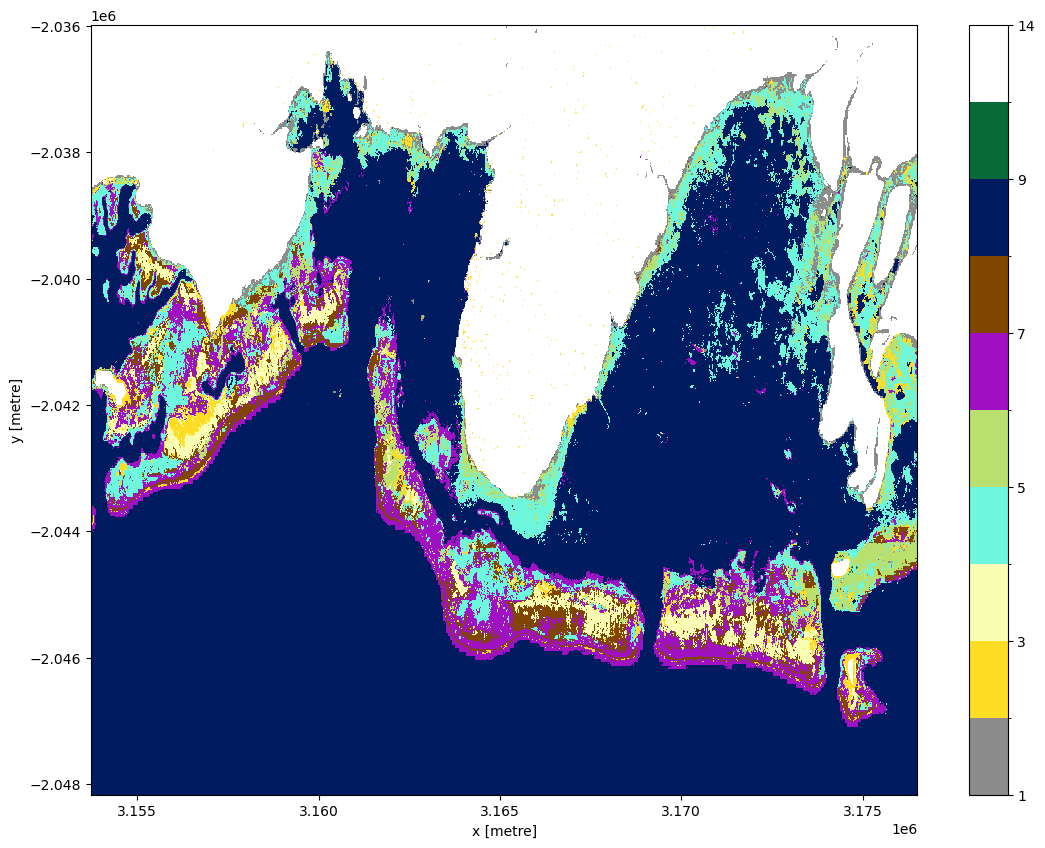

In [34]:
from matplotlib import colors

classes = [
    [1, "sediment", "#8c8c8c"],
    [2, "sand", "#fedd24"],
    [3, "rubble", "#f8ffb4"],
    [4, "seagrass", "#6df7dc"],
    [5, "seaweed", "#b9df6f"],
    [6, "coral", "#a011c3"],
    [7, "rock", "#804600"],
    [8, "deeps", "#011b61"],
    [9, "mangrove", "#086a39"],
    [10, "land", "#ffffff"],
]

values_list = [c[0] for c in classes]
color_list = [c[2] for c in classes]

# Build a listed colormap.
c_map = colors.ListedColormap(color_list)
bounds = values_list + [14]
norm = colors.BoundaryNorm(bounds, c_map.N)

predicted_da.plot.imshow(cmap=c_map, norm=norm, size=10)

## Accuracy assessment

In [ ]:
gdf

In [ ]:
# Get unique values from the column
unique_values = gdf['coastal_class'].unique()

# Print each unique value
for value in unique_values:
    print(value)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
print(len(training_array), len(gdf))  # Check the lengths of both arrays

In [ ]:
print(training_array.shape)  # Should print (n_samples, n_features)
print(gdf.cc_id.shape)  # Should print (n_samples,)

In [ ]:
# If needed, trim one array to match the other's length
# gdf = gdf[1:len(gdf)]

### Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   

Where:  
X contains the features (input variables) of your dataset (the independent variables / attributes used as predictors. The columns of the dataset including the bands etc...)   
y contains the labels (target variable).  (the target - the randomforest column / class column that states what the land cover type is. This is the target / final objective of the classification)

In this case:   
X = training_array   
y = gdf.randomforest


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(training_array, gdf.cc_id, test_size=0.2, random_state=42)

In [ ]:
y_train = y_train.astype(int)

In [ ]:
# Train your model
model.fit(X_train, y_train)

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Generate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(12, 10))  # Adjust width and height for larger plot
cm_display.plot(cmap='Blues')

In [ ]:
cm

In [ ]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')

In [ ]:
gdf

In [ ]:
from sklearn.metrics import classification_report

# report = classification_report(true_labels, predicted_labels, target_names=class_labels)
# print(report)

report = classification_report(y_test, y_pred, target_names=['sediment', 'sand', 'rubble', 'seagrass', 'seaweed', 'coral', 'rock', 'deeps', 'mangrove', 'land'])
print(report)

In [ ]:
print("Unique labels in y_test:", np.unique(y_test))
print("Unique labels in y_pred:", np.unique(y_pred))

In [ ]:
print("Length of y_test:", len(y_test))
print("Length of y_pred:", len(y_pred))